In [6]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

It seems that experimental noise does lead to more noise in the information footprint. However, my hypothesis is that the level of noise has to be bigger than the bin size (so as to facilitate a sufficient number of bin transitions) in order to lead to noise.

### Loading input data

In [7]:
_genome = []
for record in SeqIO.parse("../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [8]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [9]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [10]:
O1_1027_raw = np.load('../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Information footprint without noise for comparison

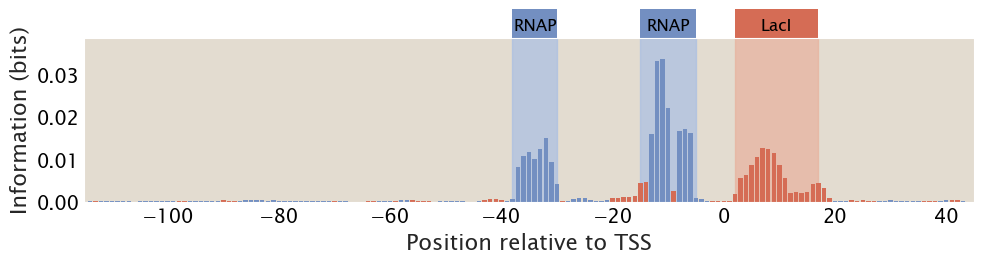

In [11]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params)

### Simulating PCR

In [12]:
def amplify(seq_cnt, rounds, p_amp=0.5):
    for round in range(rounds):
        seq_cnt = seq_cnt + np.random.binomial(seq_cnt, p_amp)
    return seq_cnt

In [13]:
def append_amplified_count(original_count, rounds):
    return amplify(original_count, rounds)

In [14]:
rounds = 30

df['ct_1_amplified'] = df.apply(lambda row: append_amplified_count(row['ct_1'], rounds), axis=1)
df['ct_1_amplified'] = df['ct_1_amplified'] / max(df['ct_1_amplified']) * 10**4
df['norm_ct_1'] = df['ct_1_amplified'] / df['ct_0']

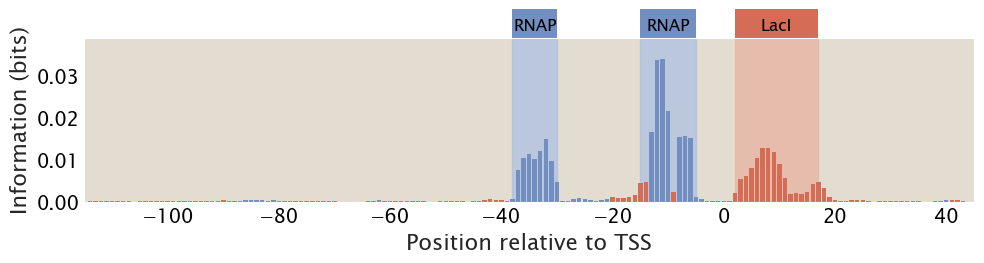

In [15]:
region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile='../plots/figS11/pcr_amplification_fp.pdf')

In [16]:
mutant_bank = []
for i in range(20):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [17]:
def get_signal(footprint, region_param):
    signal = np.sum(footprint[(region_param[0]+115):(region_param[1]+116)])
    length = region_param[1] - region_param[0] + 1
    return signal, length

In [18]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -15

l_rounds = np.arange(1, 31, 1)
l_stn_ratio_rnap10 = []
l_stn_ratio_rnap35 = []
l_stn_ratio_lacI = []
for rounds in l_rounds:
    rnap10 = []
    rnap35 = []
    lacI = []
    for j in range(20):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                preset_mutants=mutant_bank[i])
        df['ct_1_amplified'] = df.apply(lambda row: append_amplified_count(row['ct_1'], rounds), axis=1)
        df['ct_1_amplified'] = df['ct_1_amplified'] / max(df['ct_1_amplified']) * 10**4
        df['norm_ct_1'] = df['ct_1_amplified'] / df['ct_0']
        
        nbins = 2
        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
        
        region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
        rnap35_signal, rnap35_length = get_signal(footprint, region_params[0])
        rnap10_signal, rnap10_length = get_signal(footprint, region_params[1])
        lacI_signal, lacI_length = get_signal(footprint, region_params[2])

        total_signal = rnap35_signal + rnap10_signal + lacI_signal
        total_noise = np.sum(footprint) - total_signal
        mean_noise = total_noise / (160 - (rnap35_length + rnap10_length + lacI_length))
        
        rnap10.append(rnap10_signal / rnap10_length / mean_noise)
        rnap35.append(rnap35_signal / rnap35_length / mean_noise)
        lacI.append(lacI_signal / lacI_length / mean_noise)
    l_stn_ratio_rnap10.append(np.mean(rnap10))
    l_stn_ratio_rnap35.append(np.mean(rnap35))
    l_stn_ratio_lacI.append(np.mean(lacI))

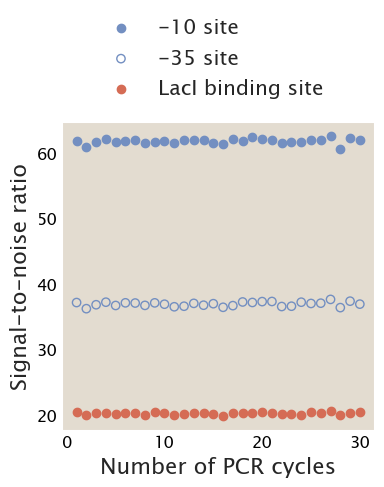

In [19]:
fig, ax = plt.subplots(figsize=(4, 5.5))
ax.scatter(l_rounds, l_stn_ratio_rnap10, label='-10 site', color='#738FC1')
ax.scatter(l_rounds, l_stn_ratio_rnap35, label='-35 site', facecolors='none', edgecolors='#738FC1', )
ax.scatter(l_rounds, l_stn_ratio_lacI, label='LacI binding site',
           color='#D56C55')
ax.set_xlabel('Number of PCR cycles', fontsize=16)
ax.set_ylabel('Signal-to-noise ratio',fontsize=16)
ax.legend(bbox_to_anchor=(0.9, 1.4), frameon=False, fontsize=15)

plt.tight_layout()
plt.savefig('../plots/figS11/amplification_bias.pdf')

### Random sampling

In [20]:
def random_sampling(df, n=10**5):
    df_large = df.loc[df.index.repeat(df.ct_1)]
    #print(len(df_large))
    #print('There are {} copies of RNA in total'.format(np.sum(df['ct_1'])))
    
    df_random = df_large.sample(n=n).drop_duplicates()
    #print('The current library size is {}'.format(len(df_random)))
    #print('Library diversity decreaes by {:.1f}%'.format( (1 - len(df_random) / len(df)) * 100))
    return df_random

In [21]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

df_random = random_sampling(df, n=int(np.sum(df['ct_1'])*0.005))

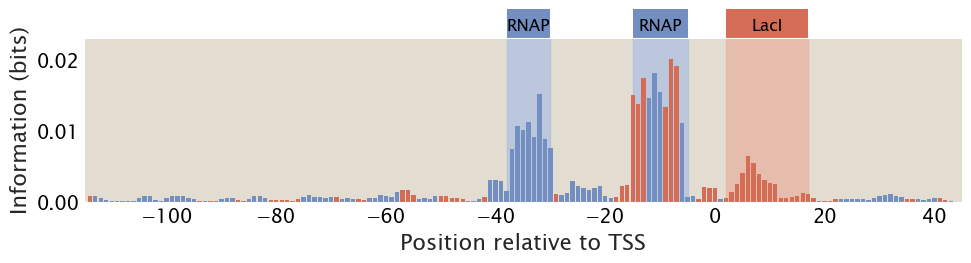

In [22]:
region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df_random, region_params,
                               outfile='../plots/figS11/random_sampling_fp.pdf')

In [23]:
mutant_bank = []
for i in range(20):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [24]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -15
alpha = 1.5
beta = 2

size = np.sum(df['ct_1'])

percentage = np.arange(0.005, 0.1, 0.005)
stn_random_sampling = []
rs_stn_ratio_rnap10 = []
rs_stn_ratio_rnap35 = []
rs_stn_ratio_lacI = []
for p in percentage:
    rv = []
    for i in range(20):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        preset_mutants=mutant_bank[i])
        df_random = random_sampling(df, n=int(p*size))

        nbins = 2
        mut_list = df_random['seq'].values
        mu_data = df_random['norm_ct_1']
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
        
        region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
        rnap35_signal, rnap35_length = get_signal(footprint, region_params[0])
        rnap10_signal, rnap10_length = get_signal(footprint, region_params[1])
        lacI_signal, lacI_length = get_signal(footprint, region_params[2])

        total_signal = rnap35_signal + rnap10_signal + lacI_signal
        total_noise = np.sum(footprint) - total_signal
        mean_noise = total_noise / (160 - (rnap35_length + rnap10_length + lacI_length))
        
        rnap10.append(rnap10_signal / rnap10_length / mean_noise)
        rnap35.append(rnap35_signal / rnap35_length / mean_noise)
        lacI.append(lacI_signal / lacI_length / mean_noise)
    rs_stn_ratio_rnap10.append(np.mean(rnap10))
    rs_stn_ratio_rnap35.append(np.mean(rnap35))
    rs_stn_ratio_lacI.append(np.mean(lacI))

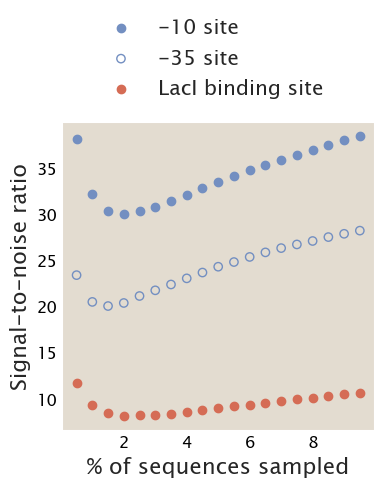

In [25]:
fig, ax = plt.subplots(figsize=(4, 5.5))
ax.scatter(percentage * 100, rs_stn_ratio_rnap10, label='-10 site', color='#738FC1')
ax.scatter(percentage * 100, rs_stn_ratio_rnap35, label='-35 site', facecolors='none', edgecolors='#738FC1', )
ax.scatter(percentage * 100, rs_stn_ratio_lacI, label='LacI binding site',
           color='#D56C55')
ax.set_xlabel('% of sequences sampled', fontsize=16)
ax.set_ylabel('Signal-to-noise ratio',fontsize=16)
ax.legend(bbox_to_anchor=(0.9, 1.4), frameon=False, fontsize=15)

plt.tight_layout()
plt.savefig('../plots/figS11/random_sampling.pdf', bbox_inches='tight')